In [3]:
from google.colab import files
uploaded = files.upload()

Saving mid_cap_all_sectors_ret.csv to mid_cap_all_sectors_ret.csv


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import seaborn as sns

data = pd.read_csv('mid_cap_all_sectors_ret.csv')
data.head()

sectors = data.drop(columns=['date'])
dates = pd.to_datetime(data['date'])


In [14]:
def detect_outliers_knn(data, n_neighbors=3):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data.reshape(-1, 1))

    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(data_scaled)

    distances, _ = knn.kneighbors(data_scaled)
    outlier_threshold = np.mean(distances) + 1 * np.std(distances)

    outliers = distances.mean(axis=1) > outlier_threshold
    return outliers, outlier_threshold

def calculate_mae(data):
    mae_value = mean_absolute_error(data[1:], data[:-1])
    return mae_value


In [15]:
def plot_sector_log_returns(ax, sector_name, log_returns, outliers, dates):
    sns.lineplot(x=dates, y=log_returns, ax=ax, label=f"{sector_name} Log Returns")
    outlier_indices = np.where(outliers)[0]
    sns.scatterplot(x=dates[outlier_indices], y=log_returns[outlier_indices],
                    color="red", ax=ax, label="Detected Outliers")

    ax.set_title(f"KNN: {sector_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Log Returns")
    ax.tick_params(axis='x', rotation=45)
    ax.legend()

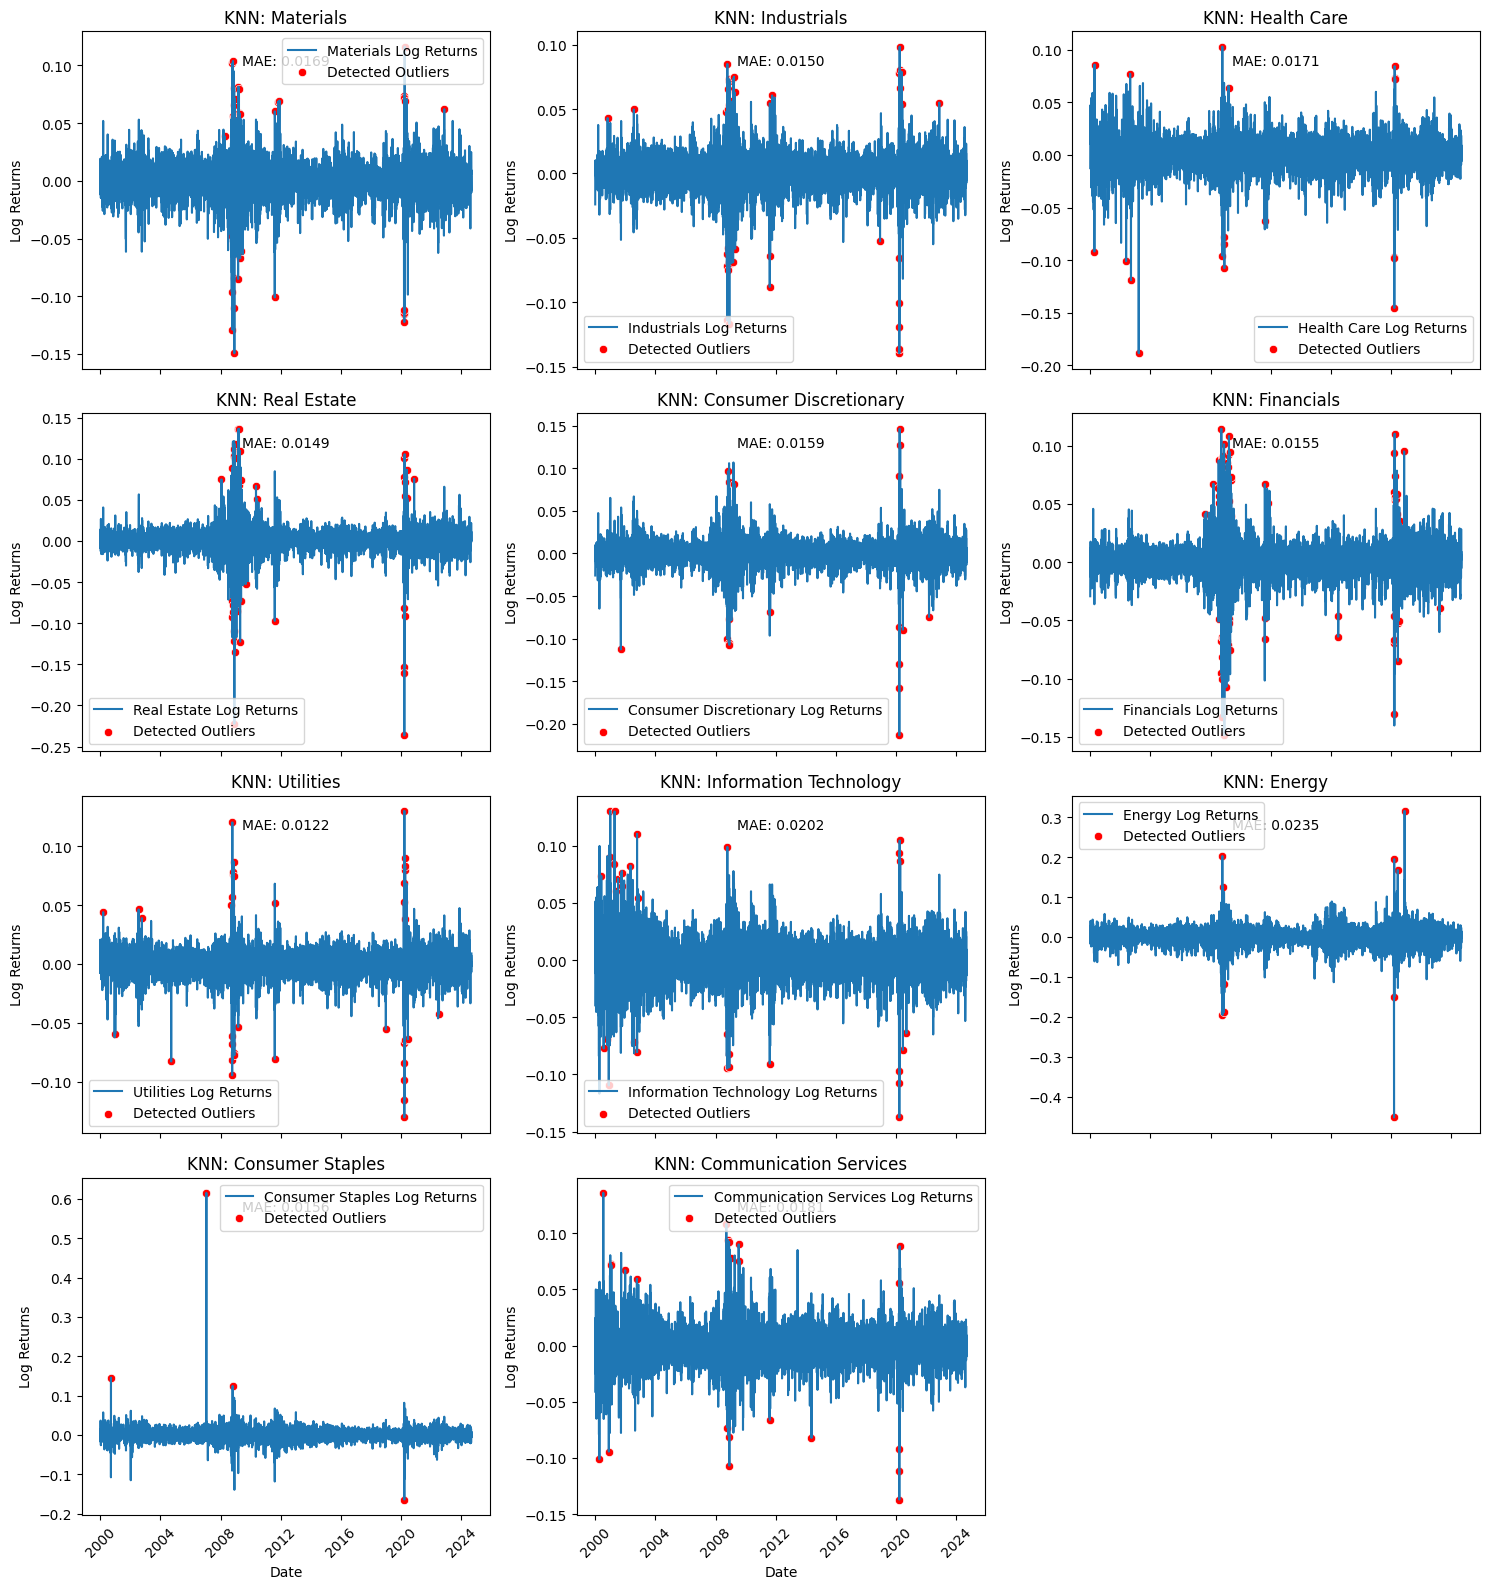

In [16]:
# Plot all sectors with fine-tuning applied
num_sectors = len(sectors.columns)
num_cols = 3
num_rows = (num_sectors + num_cols - 1) // num_cols
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows), sharex=True)
axes = axes.flatten()
dates = pd.to_datetime(data['date'])
for i, sector in enumerate(sectors.columns):
    log_returns = sectors[sector].values
    # Fine-tune the number of neighbors based on the sector's log return volatility
    sector_volatility = np.std(log_returns)
    n_neighbors = max(2, int(10 * sector_volatility))
    # Detect outliers using fine-tuned n_neighbors
    outliers, _ = detect_outliers_knn(log_returns, n_neighbors=n_neighbors)
    mae_value = calculate_mae(log_returns)
    plot_sector_log_returns(axes[i], sector, log_returns, outliers, dates)
    axes[i].text(0.5, 0.9, f"MAE: {mae_value:.4f}", transform=axes[i].transAxes, ha='center')

for j in range(i + 1, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [17]:
outlier_results = pd.DataFrame({'date': dates})

In [18]:
for sector in sectors.columns:
    log_returns = sectors[sector].values
    sector_volatility = np.std(log_returns)
    n_neighbors = max(2, int(10 * sector_volatility))  # Fine-tune neighbors
    outliers, _ = detect_outliers_knn(log_returns, n_neighbors=n_neighbors)

    # Convert boolean to int (1/0)
    outlier_results[sector] = outliers.astype(int)

In [20]:
outlier_results

,date,Materials,Industrials,Health Care,Real Estate,Consumer Discretionary,Financials,Utilities,Information Technology,Energy,Consumer Staples,Communication Services
0,2000-01-04,0,0,0,0,0,0,0,0,0,0,0
1,2000-01-05,0,0,0,0,0,0,0,0,0,0,0
2,2000-01-06,0,0,0,0,0,0,0,0,0,0,0
3,2000-01-07,0,0,0,0,0,0,0,0,0,0,0
4,2000-01-10,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
6199,2024-08-26,0,0,0,0,0,0,0,0,0,0,0
6200,2024-08-27,0,0,0,0,0,0,0,0,0,0,0
6201,2024-08-28,0,0,0,0,0,0,0,0,0,0,0
6202,2024-08-29,0,0,0,0,0,0,0,0,0,0,0


In [21]:
outlier_results.to_csv('outlier_detection_results.csv', index=False)